In [ ]:
! pip install -q langgraph langchain-core langchain-community langchain-google-genai

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from typing import TypedDict, Annotated, Literal, List
from langchain_core.messages import *
from pydantic import BaseModel, Field
import os

In [ ]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
class State (TypedDict):
  messages: Annotated[list,add_messages]
  project_name: str
  project_description: str
  features: list[str]
  user_stories: str
  product_decision: str
  product_feedback: str
  final_product_feedback: str
  functional_documentation:str
  technical_documentation:str
  combined_documentation:str
  feedback_design:str
  design_decision:str
  generated_code:str
  code_decision:str
  code_feedback:str
  code_quality_score: str

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [ ]:
class ProductOwnerRoute(BaseModel):
  step: Literal["Approved","Feedback"] = Field(description="The next step in the routing process")
  feedback: str = Field(description="If the user stories are not good, provide Feedback on how to improve them")

router_product_owner_route = llm.with_structured_output(ProductOwnerRoute)

def product_owner_review(state:State):
  message_content = state["messages"][-1].content

  decision = router_product_owner_route.invoke(
      [
          SystemMessage(content="""Route the input to Approved or Feedback based on user stories quality.
            If 'Approved', leave feedback empty or provide positive reinforcement.
            If 'Feedback', provide constructive feedback on how to improve the stories."""),
            HumanMessage(content=message_content),
      ]
  )
  print(f"Decision Step: {decision.step}")
  print(f"Feedback: {decision.feedback}")
  return {"product_decision":decision.step,"product_feedback":decision.feedback}

def route_product_decision(state:State):
    """Routes the workflow based on product owner decision."""
    if state["product_decision"] == "Feedback":
        return "Feedback"
    else:
        return "Approved"

router_product_owner_route = llm.with_structured_output(ProductOwnerRoute)


# Define the structured output for product owner routing
class DesignRoute(BaseModel):
    step: Literal["Approved", "Feedback"] = Field(description="The next step in routing process")
    feedback: str = Field(description="If the design documents are not good, provide feedback on how to improve them.")


def design_review(state: State):

  """Routes the user stories for approval or revision."""
  message_content = state["combined_documentation"]  # Extract content from last message
  decision = router_design_route.invoke(
        [
            SystemMessage(content="""Route the input to Approved or Feedback based on technical and functional document quality.
            If 'Approved', leave feedback empty or provide positive reinforcement.
            If 'Feedback', provide constructive feedback on how to improve the technical and functional document quality."""),
            HumanMessage(content=message_content),
        ]
    )
  print(f"Decision Step: {decision.step}")
  print(f"Feedback: {decision.feedback}")
  return {"design_decision": decision.step, "feedback_design": decision.feedback}


def route_design_decision(state: State):
    """Routes the workflow based on product owner decision."""
    if state["design_decision"] == "Feedback":
        return "Feedback"
    else:  # "Approved"
        return "Approved"

router_design_route = llm.with_structured_output(DesignRoute)



class CodeReviewRoute(BaseModel):
    step: Literal["Approved", "Feedback"] = Field(
        description="The next step in routing process after code review"
    )
    feedback: str = Field(
        description="If the code is not approved, provide feedback on how to improve it."
    )
    quality_score: int = Field(
        description="Code quality score from 1-5, where 5 is excellent"
    )
    issues_found: List[str] = Field(
        description="List of issues identified during code review",
        default_factory=list
    )

router_code_review_route = llm.with_structured_output(CodeReviewRoute)

def code_review(state:State):
  """Routes the user stories for approval or revision."""
  message_content = state["generated_code"]  # Extract content from last message
  # Use router_code_review_route instead of CodeReviewRoute
  decision = router_code_review_route.invoke(
        [
            SystemMessage(content="""Route the code to Approved or Feedback based on quality.
            If 'Approved', you can still provide minor suggestions for improvement.
            If 'Feedback', provide detailed feedback on critical issues that must be fixed."""),
            HumanMessage(content=message_content)
        ]
    )

  print(f"Decision Step: {decision.step}")
  print(f"Feedback: {decision.feedback}")
  return {"code_decision": decision.step, "code_feedback": decision.feedback}

def route_code_review_decision(state: State):
    """Routes the workflow based on code review decision."""
    if state["code_decision"] == "Feedback":
        return "Fix Code After Code Review"
    else:  # "Approved"
        return "Security Review"  # Move to the next step in your workflow


In [ ]:
def generate_user_stories(state:State):

  user_story_prompt = f"""
You are an expert Agile product owner specializing in user story generation. Your goal is to create well-structured user stories
that align with Agile best practices and ensure clarity for development teams. Each user story must adhere to the following:

- Clearly define the user role.
- Describe the action or feature the user needs.
- Specify the benefit or reason behind the feature.
- Include three to five well-defined acceptance criteria.
- Ensure that the user stories are clear, concise, and aligned with Agile methodologies.
- Consider the technical implementation constraints and opportunities.

**Project Details:**
- Project Name: {state["project_name"]}
- Project Description: {state["project_description"]}
- Key Features & Requirements:
{state["features"]}

**Deliverables:**
Generate at least one user story per key feature, ensuring:
- The stories follow the standard format: "As a [user role], I want [feature or action] so that [benefit or reason]."
- Each story has 3-5 acceptance criteria, formatted with bullet points.
- If applicable, include edge cases or dependencies.
- Suggest any technical constraints or opportunities the development team should be aware of.
- Add complexity estimation (story points) if appropriate.

Please generate the structured user stories below:
"""

  response = llm.invoke([user_story_prompt] + state["messages"])
  return {"messages":response,"user_stories":response}

def revise_user_stories(state:State):

  revise_prompt = f"""
You are an expert Agile product owner refining user stories based on specific feedback. Your goal is to transform these stories into production-ready specifications that development teams can implement with minimal clarification needed.

**Project Context:**
- Project Name: {state["project_name"]}
- Project Description: {state["project_description"]}
- Key Features:
{state["features"]}

**Stakeholder Feedback:**
{state["product_feedback"]}

**Original User Stories:**
{state["user_stories"]}

**Your Task:**
Transform these user stories by:
1. Ensuring perfect adherence to the format: "As a [specific user role], I want [concrete feature or action] so that [tangible benefit or business value]"
2. Providing exactly 3-5 testable acceptance criteria for each story using the Given/When/Then format
3. Eliminating all ambiguities and subjective language (e.g., "user-friendly," "intuitive")
4. Identifying dependencies between stories and noting them explicitly
5. Addressing edge cases and error conditions
6. Breaking down stories that are too large into smaller, independently valuable chunks

**Expected Output Format:**
For each user story, provide:
- The refined user story statement
- 3-5 acceptance criteria in Given/When/Then format
- Dependencies (if applicable)
- Story points estimate (if applicable)

Return the refined user stories in dictionary format to maintain compatibility with the graph structure.
"""
  revised_response = llm.invoke([revise_prompt] + state["messages"])
  return {"messages":revised_response,"final_product_feedback":revised_response}

def generate_functional_documents(state:State):
  functional_documentation_prompt = f"""
## **Functional Specification Document (FSD) Prompt**

You are an expert technical writer specializing in software documentation. Your task is to generate a **comprehensive and structured Functional Specification Document (FSD)** for a project based on the provided user stories. Ensure that the document is **clear, concise, and aligned with industry best practices**.

---

## **Project Overview**
- **Project Name**: {state["project_name"]}
- **Project Description**: {state["project_description"]}
- **Features**: {state["features"]}

## **Functional Requirements**
Define the functional requirements in detail for each user story.
{state["user_stories"]}

---
## **Functional Specification Format**
The document should be structured as follows:

### **1. Introduction**
- Provide an overview of the project and its objectives.
- Explain the business needs and the problem it addresses.
- Identify key stakeholders and target end-users.

### **2. Scope of the System**
- Clearly define what is **in scope** and **out of scope** for the system.
- List assumptions and dependencies that impact the system’s functionality.

### **3. System Features & Functionalities**
For each feature derived from user stories, include:
- **Feature Name**:
- **User Story** (format: "As a [user], I want [feature], so that [benefit]"):
- **Functional Requirement** (detailed breakdown of expected behavior):
- **Preconditions** (conditions that must be met before execution):
- **Main Flow** (step-by-step sequence of events in normal use case):
- **Alternate Flows & Edge Cases** (scenarios deviating from the main flow):
- **Postconditions** (expected state after successful execution):

### **4. User Interface (UI) Specifications**
- Describe key UI components, user interactions, and navigation flow.
- Provide wireframes or mockups (if available).
- Mention accessibility considerations and UI responsiveness.

### **5. Data Flow & Processing**
- Explain how data moves through the system and how it's processed.
- Define key data transformations, validation rules, and storage mechanisms.

### **6. Integration Points**
- List external systems, APIs, or databases the system interacts with.
- Define data exchange formats (JSON, XML, etc.) and integration protocols (REST, GraphQL, WebSockets).
- Specify API authentication and authorization mechanisms.

### **7. Security & Compliance**
- Define authentication, authorization, and access control policies.
- Mention encryption standards for data at rest and in transit.
- Address regulatory compliance (e.g., GDPR, HIPAA, ISO 27001).

### **8. Performance & Scalability Considerations**
- Specify system response times, concurrency limits, and expected throughput.
- Discuss caching strategies, load balancing, and scaling approaches.

### **9. Error Handling & Logging**
- Describe error handling strategies and fallback mechanisms.
- Define structured logging formats and log retention policies.
- Include failure recovery strategies (e.g., retry mechanisms, alerts).

### **10. Constraints & Limitations**
- Define hardware/software limitations, licensing constraints, or technology dependencies.

### **11. Acceptance Criteria & Validation**
- Define the criteria for determining feature completion and acceptance.
- Outline functional test cases, expected outcomes, and validation steps.

---

## **Output Format**
- Generate the document in **Markdown format** with well-structured headings, bullet points, and code snippets (where applicable).
- Ensure **clarity, completeness, and adherence to best practices**.
- Maintain **technical accuracy and consistency** throughout the document.
"""

  functional_response = llm.invoke([functional_documentation_prompt] + state["messages"])
  return {"messages":functional_response,"functional_documentation":functional_response}

def generate_technical_documents(state:State):
  technical_documentation_prompt = f"""
## **Technical Documentation Generation Prompt**

You are an expert **technical writer and software architect** specializing in software documentation. Your task is to generate a **detailed, structured, and well-organized technical documentation** based on the provided **Functional Specification Document (FSD)** and **User Stories**. Ensure clarity, completeness, and adherence to **industry best practices**.

---

## **Inputs**
1. **User Stories**
{state["user_stories"]}

2. **Project Details**
- **Project Name**: {state["project_name"]}
- **Project Description**: {state["project_description"]}
- **Features**: {state["features"]}

## **Documentation Structure**
The technical documentation should be structured as follows:

### **1. Introduction**
- Provide an overview of the system, including its **purpose, key objectives, and business goals**.
- Define the **target audience, stakeholders, and primary users**.
- Summarize how the system addresses business needs.

### **2. System Architecture**
- Describe the **high-level architecture** using diagrams where necessary.
- List the **technologies, frameworks, and programming languages** used.
- Explain the interaction between **backend, frontend, database, APIs, and external services**.
- Highlight **scalability considerations and system constraints**.

### **3. Features & Functionalities**
For each user story, document:
- **Feature Name**:
- **User Story** ("As a [user], I want [feature], so that [benefit]"):
- **Functional Requirement** (as detailed in the FSD):
- **Acceptance Criteria** (clear and testable conditions for completion):
- **System Behavior** (expected inputs, outputs, and interactions):
- **Edge Cases & Error Handling** (uncommon but critical scenarios):

### **4. API Documentation**
For each API endpoint, provide:
- **Endpoint URL**:
- **HTTP Method** (GET, POST, PUT, DELETE):
- **Request Parameters** (headers, query parameters, body format):
- **Response Format** (success and error responses with examples):
- **Authentication Mechanism** (OAuth, JWT, API keys):
- **Error Handling & Status Codes**:

### **5. Database Schema**
- Provide an **Entity Relationship Diagram (ERD)** or a structured description of database tables.
- Define **primary keys, foreign keys, indexes, and constraints**.
- Explain how data is stored, retrieved, and related to system functionality.

### **6. Security Considerations**
- Define **authentication and authorization mechanisms**.
- Discuss **data encryption methods** for data at rest and in transit.
- Highlight **security policies, regulatory compliance, and best practices**.

### **7. Performance & Scalability**
- Mention **caching strategies, load balancing, and rate limiting**.
- Describe system behavior under **high load conditions**.
- Identify potential **bottlenecks and optimization techniques**.

### **8. Deployment & DevOps Strategy**
- Outline the **CI/CD pipeline**, including build, test, and deployment processes.
- Describe **cloud infrastructure, containerization (Docker, Kubernetes), and orchestration tools**.
- Explain different **environments (development, staging, production)**.

### **9. Testing Strategy**
- Detail the **testing methodologies**, including:
  - **Unit Testing** (isolated component testing)
  - **Integration Testing** (testing interaction between components)
  - **Performance Testing** (stress, load, and scalability tests)
  - **Security Testing** (penetration testing, vulnerability assessment)

### **10. Maintenance & Future Enhancements**
- Define **logging and monitoring** strategies.
- Outline **error handling, alerts, and system observability tools**.
- Provide a roadmap for **future improvements and scalability planning**.

---

## **Output Format**
- Generate the documentation in **Markdown format** with structured headings, bullet points, and code blocks.
- Ensure clarity, completeness, and readability.
- Adhere to **technical writing best practices** and **industry-standard conventions**.
"""


  technical_response = llm.invoke([technical_documentation_prompt] + state["messages"])
  return {"messages":technical_response,"technical_documentation":technical_response}

def generate_combined_documentation(state: State):
  feedback_design = state.get("feedback_design", "")
  combined_documentation = f"""
# 📌 **Comprehensive Project Documentation**

This document contains both **Functional** and **Technical** specifications to provide a complete understanding of the system.

---
**Project Name**: {state["project_name"]}
**Project Description**: {state["project_description"]}

## **1️⃣ Functional Documentation**
{state['functional_documentation']}

---

## **2️⃣ Technical Documentation**
{state['technical_documentation']}

## **Feedback from Design Review**:
{feedback_design}


---

✅ **Note:** This document serves as a **single source of truth** for both functional and technical teams. It ensures that business requirements are accurately translated into technical implementations.

"""
  return {"messages":combined_documentation,"combined_documentation": combined_documentation}

def generate_code_from_documentation(state:State):

  code_generation_prompt = f"""
🔹 **Software Implementation Request** 🔹

You are a highly skilled **software engineer** specializing in **building scalable, maintainable, and secure applications**. Your task is to generate **implementation-ready code** based on the following **comprehensive documentation**.

---

## **📌 Project Overview**
- **Project Name**: {state["project_name"]}
- **Project Description**: {state["project_description"]}

---

## **📖 Refined Technical & Functional Documentation**
{state["combined_documentation"]}

## **Code Feedback**
{state.get("code_feedback", "")}

---

## **🛠️ Implementation Guidelines**
🔹 **Core Features & Functionalities**
- Implement all key features as described in the documentation.
- Ensure that business logic is correctly translated into code.

🔹 **Software Architecture & Best Practices**
- Follow modular and scalable **code architecture**.
- Ensure **separation of concerns (SoC)** for better maintainability.
- Implement **design patterns** where applicable (MVC, Repository, etc.).
- Use **efficient data structures and algorithms** where needed.

🔹 **API Development**
- Define **RESTful API endpoints** or **GraphQL schemas** (as per documentation).
- Implement CRUD operations and necessary **authentication & authorization**.
- Follow **proper API versioning and documentation** (e.g., OpenAPI/Swagger).

🔹 **Database & Storage**
- Define **optimized database schemas** (SQL/NoSQL as per requirements).
- Ensure **indexing, normalization, and query optimization**.
- Implement **data validation and integrity constraints**.

🔹 **Security & Error Handling**
- Use **robust error handling mechanisms** (try-except, proper logging).
- Implement **input validation & sanitization** to prevent security vulnerabilities (SQL injection, XSS, CSRF, etc.).
- Ensure **secure authentication & authorization** (JWT, OAuth, etc.).
- Follow **secure coding principles** to mitigate common threats.

🔹 **Performance & Scalability**
- Optimize for **low-latency API responses**.
- Implement **caching mechanisms** (Redis, Memcached) for performance.
- Ensure **asynchronous processing** where needed (Celery, AsyncIO, Kafka).

🔹 **Code Readability & Documentation**
- Provide **meaningful comments and docstrings**.
- Maintain **consistent code formatting and naming conventions**.
- Structure code for **readability and ease of collaboration**.

---

## **📌 Expected Output**
- **Fully structured implementation-ready code**.
- Well-organized modules and functions.
- Code snippets in **appropriate files & folders**.
- Necessary configurations, environment variables, and setup instructions.

🚀 **Deliver the code in a well-structured format with explanations where necessary.**
"""
  code_response = llm.invoke([code_generation_prompt] + state["messages"])
  return {"messages":code_response,"generated_code":code_response}


def fix_code_after_code_review(state:State):
  code_review_prompt = f"""
🔍 **Comprehensive Code Review Request** 🔍

You are an **expert software engineer and code reviewer** with deep expertise in **clean code, performance optimization, and security best practices**.
Your task is to **critically evaluate** the following code and provide **a detailed, structured review**.

---

## **📌 Project Overview**
- **Project Name**: {state["project_name"]}
- **Project Description**: {state["project_description"]}

---

## **📖 Generated Code for Review**
{state["generated_code"]}

## **Feedback for code**
{state.get("code_feedback", "")}

---

## **🛠️ Code Review Guidelines**
Please review the code against the following **critical areas** and provide detailed feedback:

### ✅ **1. Code Quality & Readability**
- Is the code **clean, well-structured, and modular**?
- Are **function and variable names** meaningful and self-explanatory?
- Are there **sufficient comments and docstrings** where needed?

### 🐛 **2. Bug Detection & Logic Errors**
- Identify any **logical errors or unexpected behaviors**.
- Check for **incorrect assumptions, undefined variables, or faulty conditions**.

### 🔒 **3. Security Best Practices**
- Are there **potential security vulnerabilities** (e.g., SQL injection, XSS, CSRF, etc.)?
- Is **authentication & authorization** implemented securely?
- Are **sensitive data handling & encryption** properly managed?

### 🚀 **4. Performance & Optimization**
- Are there any **performance bottlenecks**?
- Can the code be optimized using **better algorithms or data structures**?
- Are there **unnecessary computations, redundant loops, or excessive database calls**?

### 📏 **5. Adherence to Best Practices**
- Does the code follow **industry-standard coding conventions** (PEP8 for Python, Airbnb for JavaScript, etc.)?
- Is there proper **error handling & exception management**?
- Are dependencies and third-party libraries **used efficiently**?

### ⚙ **6. Feature Implementation & Completeness**
- Does the code **fully implement all required features** as per the documentation?
- Are **all functionalities covered**, or are there any missing elements?

---

## **📌 Expected Output**
Provide a **structured review** with the following details:
1️⃣ **Quality Score (1-5)** based on overall assessment.
2️⃣ **List of identified issues** categorized by severity (Critical, Major, Minor).
3️⃣ **Suggested improvements** for each issue.
4️⃣ **Approval Status**:
   - ✅ **Approved**: If the code is production-ready.
   - 📝 **Needs Revisions**: If improvements are necessary before approval.

🚀 **Your insights will help ensure high-quality, secure, and maintainable software.**
"""

  code_review_response = llm.invoke([code_review_prompt] + state["messages"])
  return {"messages":code_review_response,"code_quality_score":code_review_response}

def security_review(state:State):
  pass


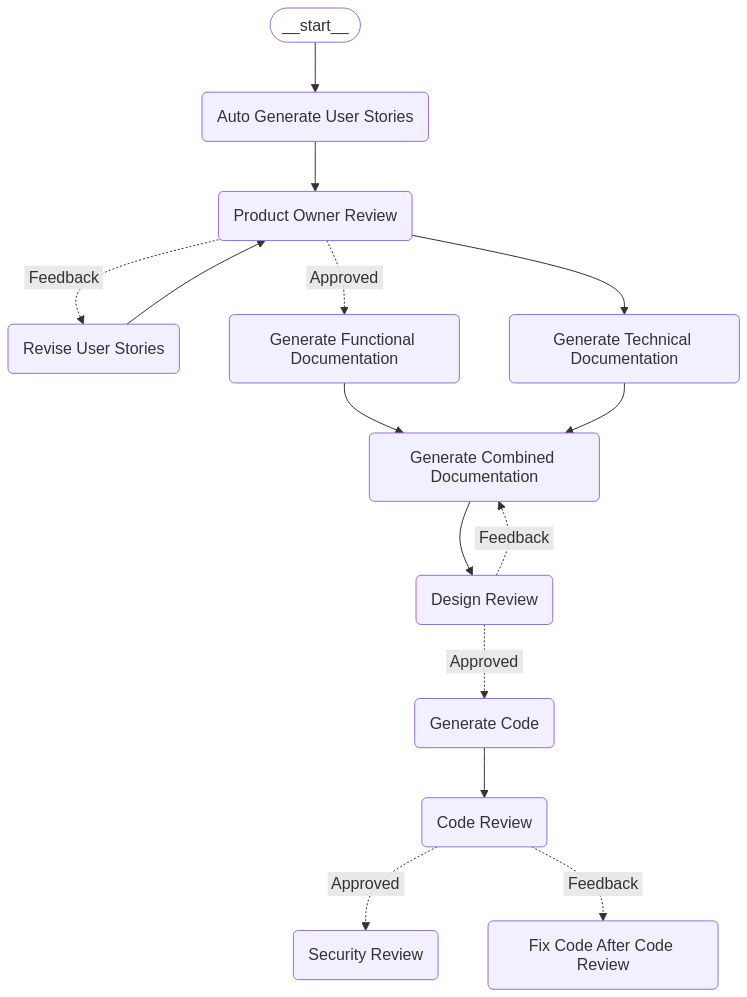

In [ ]:
builder = StateGraph(State)

builder.add_node("Auto Generate User Stories", generate_user_stories)
builder.add_node("Product Owner Review", product_owner_review)
builder.add_node("Revise User Stories", revise_user_stories)
builder.add_node("Generate Functional Documentation", generate_functional_documents)
builder.add_node("Generate Technical Documentation", generate_technical_documents)
builder.add_node("Generate Combined Documentation", generate_combined_documentation)
builder.add_node("Design Review", design_review)
builder.add_node("Generate Code", generate_code_from_documentation)
builder.add_node("Code Review",code_review)
builder.add_node("Fix Code After Code Review", fix_code_after_code_review)
builder.add_node("Security Review",security_review)


builder.add_edge(START, "Auto Generate User Stories")
builder.add_edge("Auto Generate User Stories","Product Owner Review")

builder.add_conditional_edges(
    "Product Owner Review",
    route_product_decision,
    {
        "Approved": "Generate Functional Documentation",
        "Feedback": "Revise User Stories"
    }
)
builder.add_edge("Revise User Stories","Product Owner Review")
builder.add_edge("Product Owner Review", "Generate Technical Documentation")
builder.add_edge("Generate Technical Documentation", "Generate Combined Documentation")
builder.add_edge("Generate Functional Documentation", "Generate Combined Documentation")
builder.add_edge("Generate Combined Documentation", "Design Review")

builder.add_conditional_edges(
    "Design Review",
    route_design_decision,
    {
        "Approved": "Generate Code",
        "Feedback": "Generate Combined Documentation"
    }
)

builder.add_edge("Generate Code", "Code Review")

builder.add_conditional_edges(
    "Code Review",
    router_code_review_route,
    {
        "Approved": "Security Review",
        "Feedback": "Fix Code After Code Review"
    }
)

# builder.add_edge("Fix Code After Code Review", "Code Review")


graph = builder.compile()
graph

In [ ]:
sample = {
    "project_name": "MeetingMind",
    "project_description": "MeetingMind is an AI-powered tool that automatically transcribes, summarizes, and generates actionable insights from meetings. It ensures key discussions are captured and follow-ups are assigned.",
    "features": '''
    Real-time meeting transcription
AI-generated action items and summaries
Multi-speaker identification
Integration with Zoom, Google Meet, and Teams
Sentiment analysis and topic categorization
    '''
}

response = graph.invoke(sample)

for m in response["messages"]:
  m.pretty_print()

Decision Step: Approved
Feedback: The user stories are well-written and provide a good level of detail. The acceptance criteria are clear and testable, and the technical constraints/opportunities section demonstrates a good understanding of the underlying technologies. The story points seem reasonable for the complexity of each story.
Decision Step: Approved
Feedback: The documentation is well-structured and comprehensive, covering both functional and technical aspects of the MeetingMind project. The inclusion of diagrams, code snippets, and detailed descriptions enhances understanding. The document effectively translates business requirements into technical specifications, serving as a valuable resource for development, testing, and deployment.


ValidationError: 21 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=AIMessage(content='Okay, ...ls': {'cache_read': 0}}), input_type=AIMessage]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', 'Okay, here\'...vironment.  Good luck!'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', 'Okay, here\'...vironment.  Good luck!'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {'p..., 'safety_ratings': []}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {'p..., 'safety_ratings': []}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', 'run-adcb81e5-24d2...5d-9796-4c87c7118fd4-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', 'run-adcb81e5-24d2...5d-9796-4c87c7118fd4-0'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].7.str
  Input should be a valid string [type=string_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].7.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].8.str
  Input should be a valid string [type=string_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].8.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type
content.list[union[str,dict[any,any]]].9.str
  Input should be a valid string [type=string_type, input_value=('usage_metadata', {'inpu...ls': {'cache_read': 0}}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
content.list[union[str,dict[any,any]]].9.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('usage_metadata', {'inpu...ls': {'cache_read': 0}}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.10/v/dict_type